In [1]:
import numpy as np
import cv2
from scipy.spatial import Delaunay

import matplotlib.pyplot as plt

In [2]:
DEFINED = 0
UNDEFINED = 255

origin = (15, 15)
mask = cv2.imread("data/knn_unittest.png", cv2.IMREAD_GRAYSCALE)

In [3]:
def display_neighbors(mask: np.ndarray, origin: tuple, neighbors: list[tuple]):
    fig, axis = plt.subplots(1, 1, figsize=(6,6))
    axis.imshow(mask, cmap="Greys", alpha=0.5)
    axis.scatter(y=[origin[0]], x=[origin[1]], c="red")
    axis.scatter(y=[n[0] for n in neighbors], x=[n[1] for n in neighbors])
    
    axis.set_xticks([])
    axis.set_yticks([])

    plt.show()

In [4]:
def euclidean_distance(point1: tuple[int, int], point2: tuple[int, int]) -> float:
    p1_y, p1_x = point1
    p2_y, p2_x = point2

    return np.sqrt((p2_y - p1_y) ** 2 + (p2_x - p1_x) ** 2)

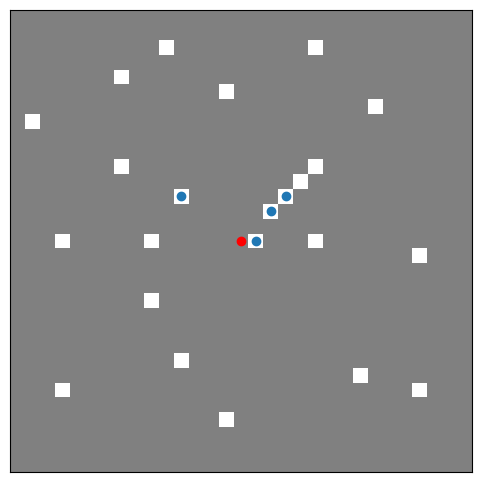

In [5]:
def nn_bruteforce(mask: np.ndarray, origin: tuple, k: int) -> list[tuple]:
    neighbors = []
    height, width = mask.shape

    for y in range(height):
        for x in range(width):
            if mask[y, x] == DEFINED:
                neighbors.append((y, x, euclidean_distance(origin, (y, x))))

    # candidates = np.argwhere(mask == DEFINED)
    # for y, x in candidates:
    #     neighbors.append((y, x, euclidean_distance(origin, (y, x))))

    neighbors = sorted(neighbors, key=lambda item: item[2])
    return neighbors[0: k]

neighbors = nn_bruteforce(mask, origin, 4)
display_neighbors(mask, origin, neighbors)

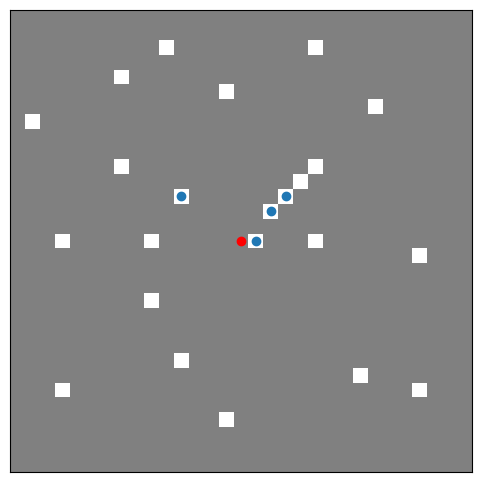

In [6]:
def nn_bruteforce_numpy(mask: np.ndarray, origin: tuple, k: int) -> list[tuple]:
    neighbors = []
    candidates = np.argwhere(mask == DEFINED)
    for y, x in candidates:
        neighbors.append((y, x, euclidean_distance(origin, (y, x))))

    neighbors = sorted(neighbors, key=lambda item: item[2])
    return neighbors[0: k]

neighbors = nn_bruteforce(mask, origin, 4)
display_neighbors(mask, origin, neighbors)

In [7]:
def nn_delaunay(mask: np.ndarray, origin: tuple, k: int) -> list[tuple]:
    neighbors, queue, visited  = [], [], []
    radius = np.inf
    tri = Delaunay(np.argwhere(mask == DEFINED), incremental=True)  # do this only once later
    tri.add_points([origin])
    indptr, indices = tri.vertex_neighbor_vertices

    start_node_index = len(tri.points) - 1
    queue.append(start_node_index)
    visited.append(start_node_index)
    while queue:
        index = queue.pop(0)
        if index != start_node_index:
            p_y, p_x = tri.points[index]
            neighbors.append((p_y, p_x, euclidean_distance(origin, (p_y, p_x))))
            neighbors = sorted(neighbors, key=lambda item: item[2])
            neighbors = neighbors[0: k]
            if len(neighbors) == k:
                radius = neighbors[-1][2]

        neighbor_indices = indices[indptr[index]: indptr[index+1]]
        for neighbor_index in neighbor_indices:
            pn_y, pn_x = tri.points[neighbor_index]
            if (neighbor_index not in visited) and (euclidean_distance(origin, (pn_y, pn_x)) < radius):
                queue.append(neighbor_index)
                visited.append(neighbor_index)

    fig, axis = plt.subplots(1, 1, figsize=(6,6))
    axis.imshow(mask, cmap="Greys", alpha=0.5)
    axis.triplot(tri.points[:,1], tri.points[:,0], tri.simplices)
    axis.scatter(y=[origin[0]], x=[origin[1]], c="red")
    plt.show()

    return neighbors

neighbors = nn_delaunay(mask, origin, 4)
display_neighbors(mask, origin, neighbors)

NameError: name 'nn_delaunay_2' is not defined

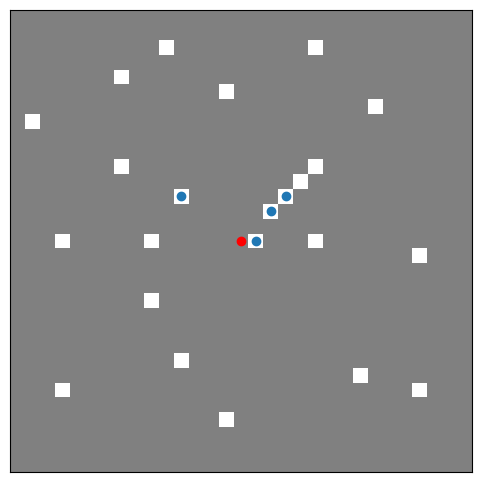

In [ ]:
def nn_quadratic(mask: np.ndarray, origin: tuple, k: int) -> list[tuple]:
    neighbors = []
    origin_y, origin_x = origin
    height, width = mask.shape

    max_distance = max(origin_y, height - origin_y, origin_x, width - origin_x)

    for distance in range(1, max_distance):
        y_t, y_b = origin_y - distance, origin_y + distance
        x_l, x_r = origin_x - distance, origin_x + distance

        for y in range(y_t, y_b + 1):
            if 0 <= y < height:
                if x_l >= 0 and mask[y, x_l] == DEFINED:
                    neighbors.append((y, x_l, euclidean_distance(origin, (y, x_l))))
                if x_r < width and mask[y, x_r] == DEFINED:
                    neighbors.append((y, x_r, euclidean_distance(origin, (y, x_r))))

        for x in range(x_l + 1, x_r):
            if 0 <= x < width:
                if y_t >= 0 and mask[y_t, x] == DEFINED:
                    neighbors.append((y_t, x, euclidean_distance(origin, (y_t, x))))
                if y_b < height and mask[y_b, x] == DEFINED:
                    neighbors.append((y_b, x, euclidean_distance(origin, (y_b, x))))

        if len(neighbors) >= k:
            neighbors = sorted(neighbors, key=lambda item: item[2])
            neighbors = neighbors[0 :k]
            if neighbors[-1][2] < distance:
                break

    return neighbors

neighbors = nn_quadratic(mask, origin, 4)
display_neighbors(mask, origin, neighbors)

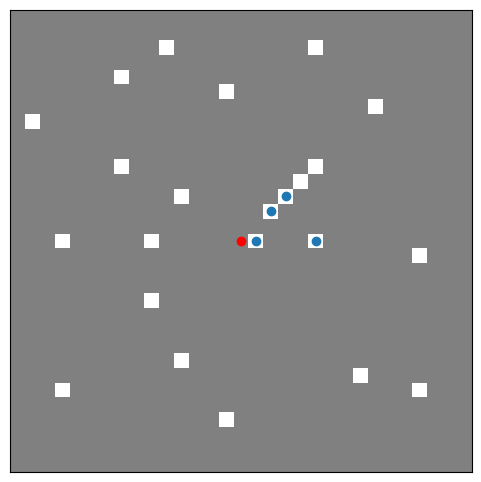

In [ ]:
def nn_circle(mask: np.ndarray, origin: tuple, k: int) -> list[tuple]:
    neighbors = set()
    origin_y, origin_x = origin
    height, width = mask.shape

    furthest_pixel = round(max(euclidean_distance(origin, (0, 0)), euclidean_distance(origin, (height, 0)), euclidean_distance(origin, (0, width)), euclidean_distance(origin, (height, width))))

    discretization = np.linspace(0, 2, 360) * np.pi
    for distance in range(1, furthest_pixel):
        Y = np.round(distance * np.cos(discretization) + origin_y).astype(int)
        X = np.round(distance * np.sin(discretization) + origin_x).astype(int)

        for y, x in zip(Y, X):
            if 0 <= y < height and 0 <= x < width and mask[y, x] == DEFINED:
                neighbors.add((y, x))
                if len(neighbors) == k:
                    return list(neighbors)

    return list(neighbors)

neighbors = nn_circle(mask, origin, 4)
display_neighbors(mask, origin, neighbors)

In [ ]:
import unittest

class TestNN(unittest.TestCase):

    def get_default_mask_params(self):
        origin = (15, 15)
        mask = cv2.imread("data/knn_unittest.png", cv2.IMREAD_GRAYSCALE)
        k = 4
        gt = [(15, 16), (15, 20), (13, 17), (12, 18), (12, 11)]

        return mask, origin, k, gt
    
    def get_quadratic_mask_params_corner(self):
        origin = (15, 15)
        mask = np.full((31, 31), 255)
        mask[1, 1] = 0
        mask[29, 29] = 0
        mask[15, 0] = 0
        mask[15, 30] = 0
        k = 2
        gt = [(15, 0), (15, 30)]

        return mask, origin, k, gt
    
    def get_circle_mask_params_corner(self):
        origin = (15, 15)
        mask = np.full((31, 31), 255)
        mask[0, 0] = 0
        mask[30, 30] = 0
        k = 2
        gt = [(0, 0), (30, 30)]

        return mask, origin, k, gt

    def test_bruteforce_default(self):
        mask, origin, k, gt = self.get_default_mask_params()
        neighbors = nn_bruteforce(mask, origin, k)
        neighbors = [(n[0], n[1]) for n in neighbors]
        self.assertTrue(set(gt).issuperset(set(neighbors)))

    def test_quadratic_default(self):
        mask, origin, k, gt = self.get_default_mask_params()
        neighbors = nn_quadratic(mask, origin, k)
        neighbors = [(n[0], n[1]) for n in neighbors]
        self.assertTrue(set(gt).issuperset(set(neighbors)))

    def test_circle_default(self):
        mask, origin, k, gt = self.get_default_mask_params()
        neighbors = nn_circle(mask, origin, k)
        neighbors = [(n[0], n[1]) for n in neighbors]
        self.assertTrue(set(gt).issuperset(set(neighbors)))

    def test_quadratic_corner(self):
        mask, origin, k, gt = self.get_quadratic_mask_params_corner()
        neighbors = nn_quadratic(mask, origin, k)
        neighbors = [(n[0], n[1]) for n in neighbors]
        self.assertTrue(set(gt).issuperset(set(neighbors)))

    def test_circle_corner(self):
        mask, origin, k, gt = self.get_circle_mask_params_corner()
        neighbors = nn_circle(mask, origin, k)
        neighbors = [(n[0], n[1]) for n in neighbors]
        self.assertTrue(set(gt).issuperset(set(neighbors)))


unittest.main(argv=[""], verbosity=1, exit=False)

.....
----------------------------------------------------------------------
Ran 5 tests in 0.009s

OK


In [ ]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [ ]:
fill_factors = np.linspace(0.01, 1, 99, endpoint=False)

def profile_nn_f(nn_f):
    for _ in range(100):
        mask = np.random.rand(201, 201)
        mask = np.where(mask < 0.01, DEFINED, UNDEFINED)
        origin = (100, 100)
        k = 10
        neighbors = nn_f(mask, origin, k)



In [ ]:
%lprun -f nn_bruteforce profile_nn_f(nn_bruteforce)

Timer unit: 1e-09 s

Total time: 1.52693 s
File: /tmp/ipykernel_6635/2470931320.py
Function: nn_bruteforce at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def nn_bruteforce(mask: np.ndarray, origin: tuple, k: int) -> list[tuple]:
     2       100      29216.0    292.2      0.0      neighbors = []
     3       100      60758.0    607.6      0.0      height, width = mask.shape
     4                                           
     5     20200    2373636.0    117.5      0.2      for y in range(height):
     6   4060200  503510924.0    124.0     33.0          for x in range(width):
     7   4040100  945306127.0    234.0     61.9              if mask[y, x] == DEFINED:
     8     40029   63349431.0   1582.6      4.1                  neighbors.append((y, x, euclidean_distance(origin, (y, x))))
     9                                           
    10                                               # candidates = np.argwhe

In [ ]:
%lprun -f nn_bruteforce_numpy profile_nn_f(nn_bruteforce_numpy)

Timer unit: 1e-09 s

Total time: 0.119816 s
File: /tmp/ipykernel_6635/2638980425.py
Function: nn_bruteforce_numpy at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def nn_bruteforce_numpy(mask: np.ndarray, origin: tuple, k: int) -> list[tuple]:
     2       100      27190.0    271.9      0.0      neighbors = []
     3       100    9620928.0  96209.3      8.0      candidates = np.argwhere(mask == DEFINED)
     4     40340   33880417.0    839.9     28.3      for y, x in candidates:
     5     40240   64498406.0   1602.8     53.8          neighbors.append((y, x, euclidean_distance(origin, (y, x))))
     6                                           
     7       100   11733242.0 117332.4      9.8      neighbors = sorted(neighbors, key=lambda item: item[2])
     8       100      55730.0    557.3      0.0      return neighbors[0: k]

In [ ]:
%lprun -f nn_quadratic profile_nn_f(nn_quadratic)

Timer unit: 1e-09 s

Total time: 0.0743647 s
File: /tmp/ipykernel_6635/2555324451.py
Function: nn_quadratic at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def nn_quadratic(mask: np.ndarray, origin: tuple, k: int) -> list[tuple]:
     2       100      26663.0    266.6      0.0      neighbors = []
     3       100      16420.0    164.2      0.0      origin_y, origin_x = origin
     4       100      40126.0    401.3      0.1      height, width = mask.shape
     5                                           
     6       100      71269.0    712.7      0.1      max_distance = max(origin_y, height - origin_y, origin_x, width - origin_x)
     7                                           
     8      1853     286783.0    154.8      0.4      for distance in range(1, max_distance):
     9      1853     254235.0    137.2      0.3          y_t, y_b = origin_y - distance, origin_y + distance
    10      1853     231246.0    12

In [ ]:

%lprun -f nn_circle profile_nn_f(nn_circle)

Timer unit: 1e-09 s

Total time: 0.537503 s
File: /tmp/ipykernel_6635/1203335792.py
Function: nn_circle at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def nn_circle(mask: np.ndarray, origin: tuple, k: int) -> list[tuple]:
     2       100      48301.0    483.0      0.0      neighbors = set()
     3       100      22650.0    226.5      0.0      origin_y, origin_x = origin
     4       100      42628.0    426.3      0.0      height, width = mask.shape
     5                                           
     6       100    1103736.0  11037.4      0.2      furthest_pixel = round(max(euclidean_distance(origin, (0, 0)), euclidean_distance(origin, (height, 0)), euclidean_distance(origin, (0, width)), euclidean_distance(origin, (height, width))))
     7                                           
     8       100    2682908.0  26829.1      0.5      discretization = np.linspace(0, 2, 360) * np.pi
     9      1798     33528